In [1]:
import tensorflow as tf

import pandas as pd, numpy as np
import os, unidecode, glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

In [2]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)

In [3]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [4]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df = df.assign(date=df.date.dt.round('H'))
df.head()

,business_id,city,date
0,EosRKXIGeSWFYWwpkbhNnA,Toronto,2012-06-12 19:00:00
1,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-11 15:00:00
2,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-22 18:00:00
3,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-05 21:00:00
4,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-06 17:00:00


In [5]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16 02:00:00,0,1,0,0,0,0,0,0,0,0
2010-01-16 05:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 10:00:00,0,0,0,0,0,0,0,0,2,0
2010-01-16 13:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 15:00:00,0,1,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-13 13:00:00,0,0,0,0,0,1,1,0,4,0
2019-12-13 14:00:00,0,0,0,0,0,0,1,0,4,0
2019-12-13 15:00:00,0,0,3,1,2,0,0,0,5,0


In [6]:
hourly_tor = pivot_df.loc[:,'Toronto'].resample('H').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

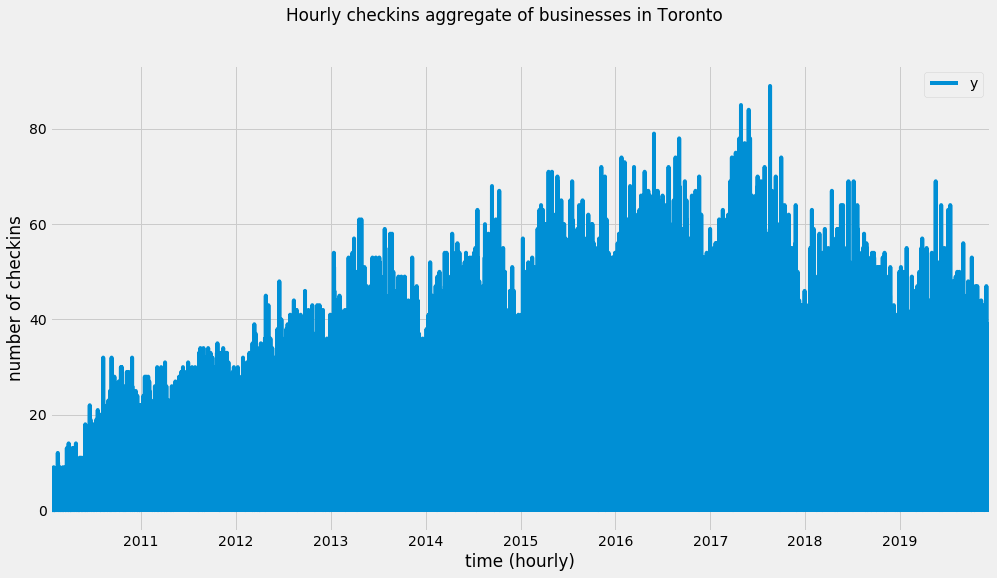

In [7]:
fig, ax = plt.subplots()
hourly_tor.plot(ax=ax)
fig.suptitle('Hourly checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (hourly)',ylabel=('number of checkins'))
plt.legend()
plt.show()

In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [9]:
TRAIN_SPLIT = hourly_tor.loc[hourly_tor.index<'2019-01-01 00:00:00',:].shape[0]
tf.random.set_seed(13)

In [10]:
uni_data = hourly_tor.values

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
print(uni_train_mean,uni_train_std)

11.90978784096987 12.48439462792663


In [12]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

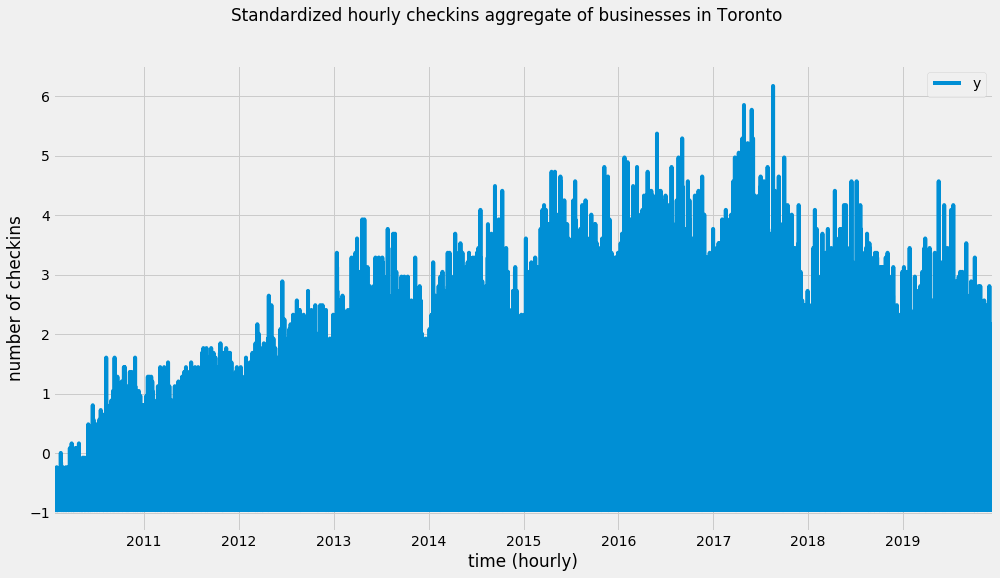

In [13]:
fig, ax = plt.subplots()
pd.DataFrame(uni_data,index=hourly_tor.index,columns=['y']).plot(ax=ax)
fig.suptitle('Standardized hourly checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (hourly)',ylabel=('number of checkins'))
plt.legend()
plt.show()

In [14]:
univariate_past_history = 3*24
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.873874]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.793774]
 [-0.953974]
 [-0.953974]
 [-0.873874]
 [-0.953974]
 [-0.793774]
 [-0.873874]
 [-0.713674]
 [-0.953974]
 [-0.313174]
 [-0.713674]
 [-0.633574]
 [-0.953974]
 [-0.873874]
 [-0.713674]
 [-0.393274]
 [-0.793774]
 [-0.953974]
 [-0.873874]
 [-0.873874]
 [-0.873874]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.873874]
 [-0.953974]
 [-0.873874]
 [-0.873874]
 [-0.873874]
 [-0.713674]
 [-0.953974]
 [-0.713674]
 [-0.873874]
 [-0.873874]
 [-0.713674]
 [-0.873874]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.873874]
 [-0.873874]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.953974]
 [-0.873874]
 [-0.873874]
 [-0.953974]
 [-0.633574]
 [-0.633574]
 [-0.953974]
 [-0.793774]
 [-0.873874]
 [-0.873874]
 [-0.953974]
 [-0.793774]
 [-0.713674]
 [-0.953974]]

 Target temperature to predict
[

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

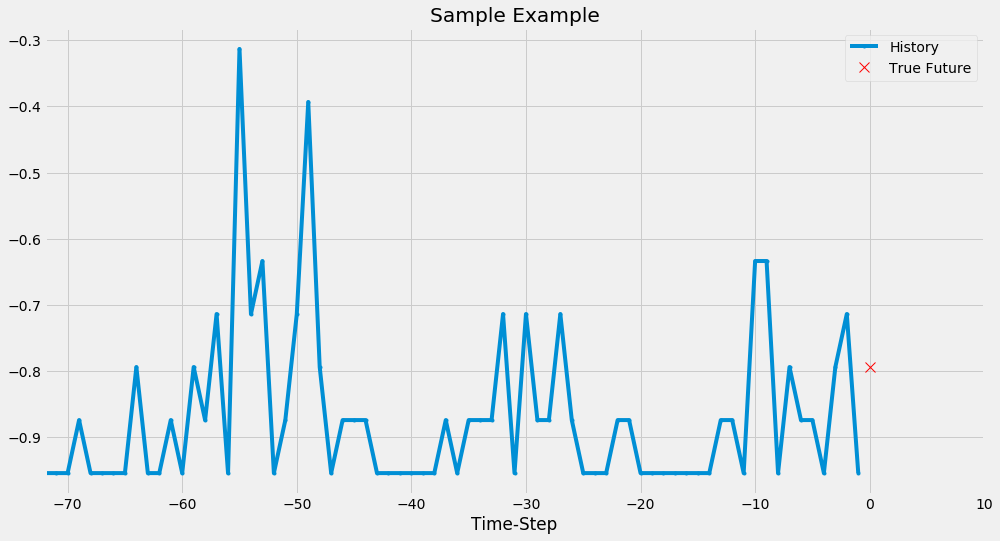

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plt.show()

In [19]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'I:\\Installed\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

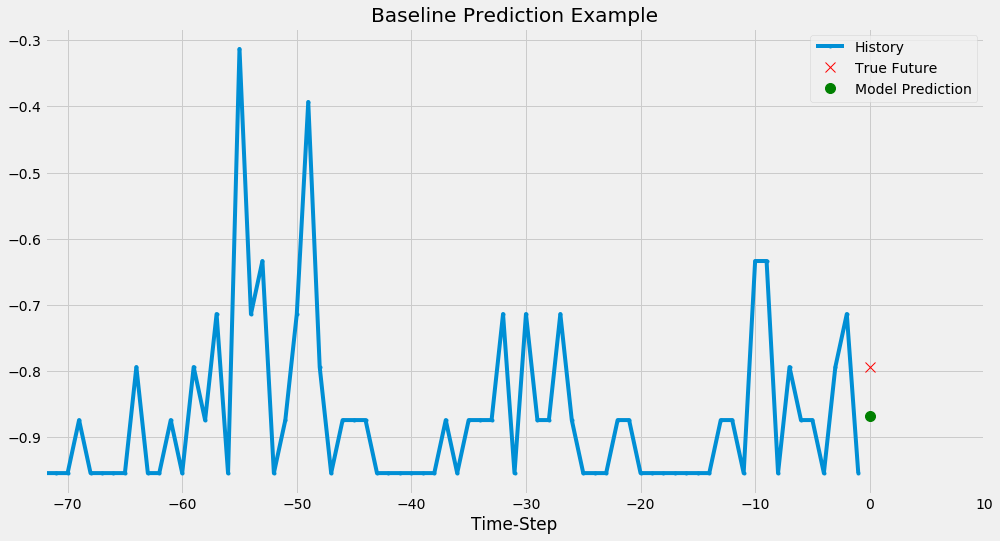

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## LSTM

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2443 - val_loss: 0.2476
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2451 - val_loss: 0.2483
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2735 - val_loss: 0.2356
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2435 - val_loss: 0.2528
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2476 - val_loss: 0.2563
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2719 - val_loss: 0.2390
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2417 - val_loss: 0.2515
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2515 - val_loss: 0.2560
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2706 - val_loss: 0.2359
Epoch 10/10
200/200 [===========================

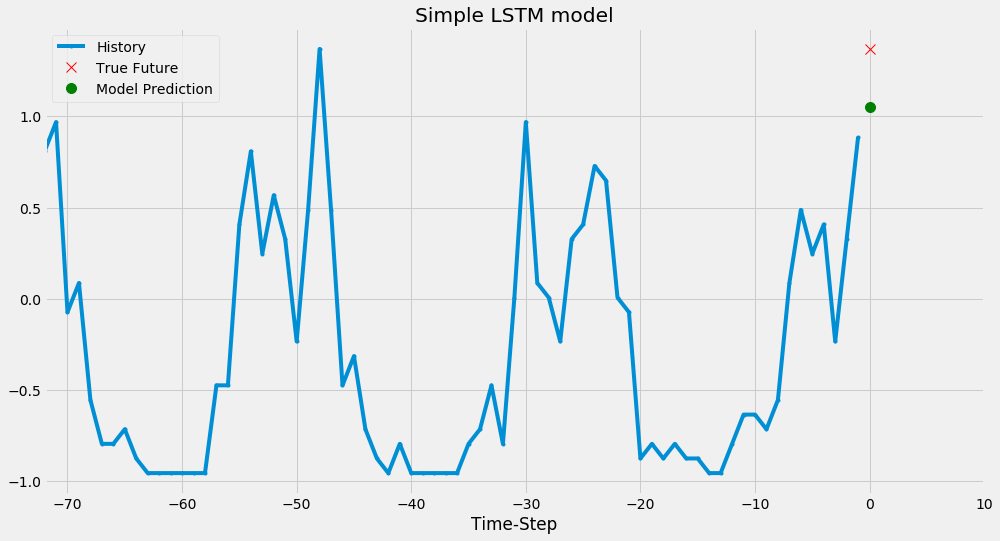

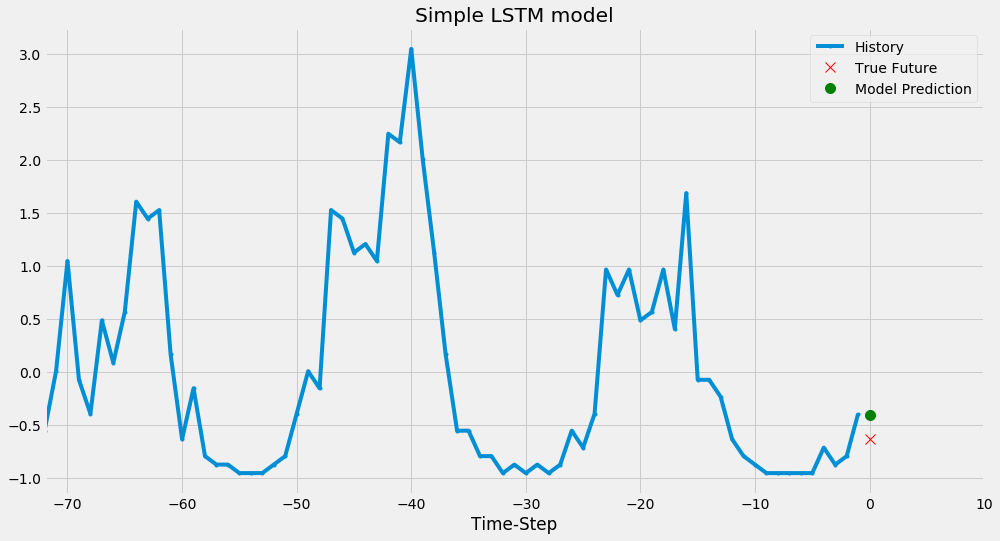

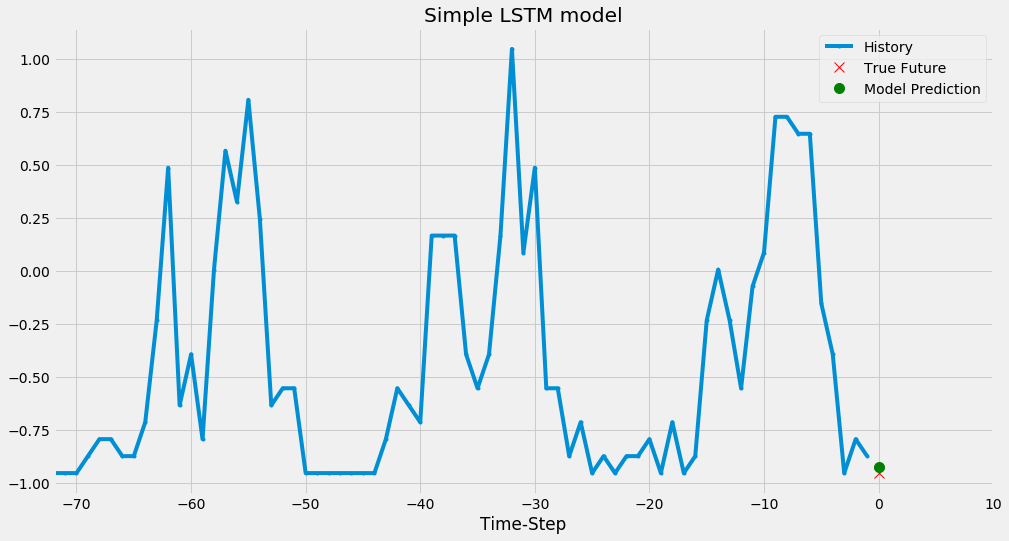

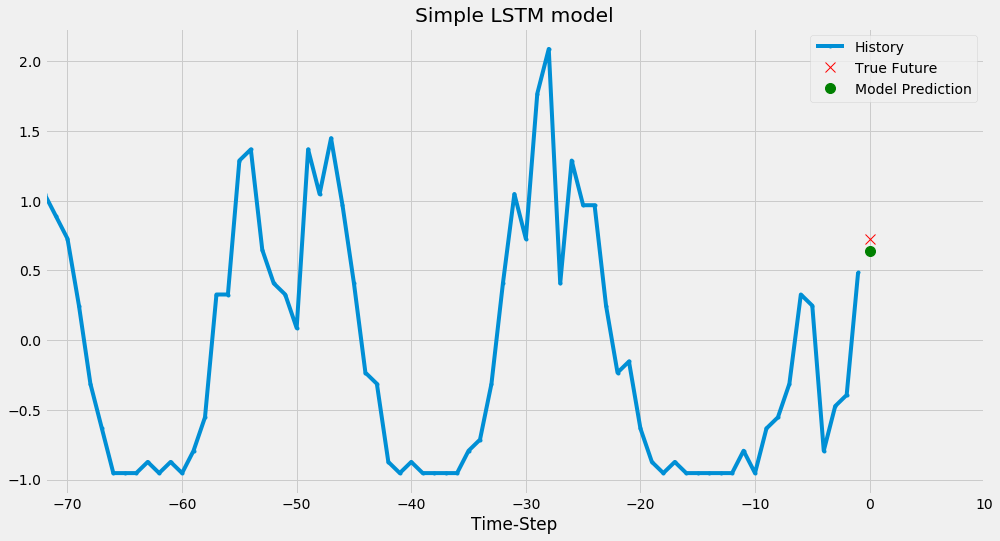

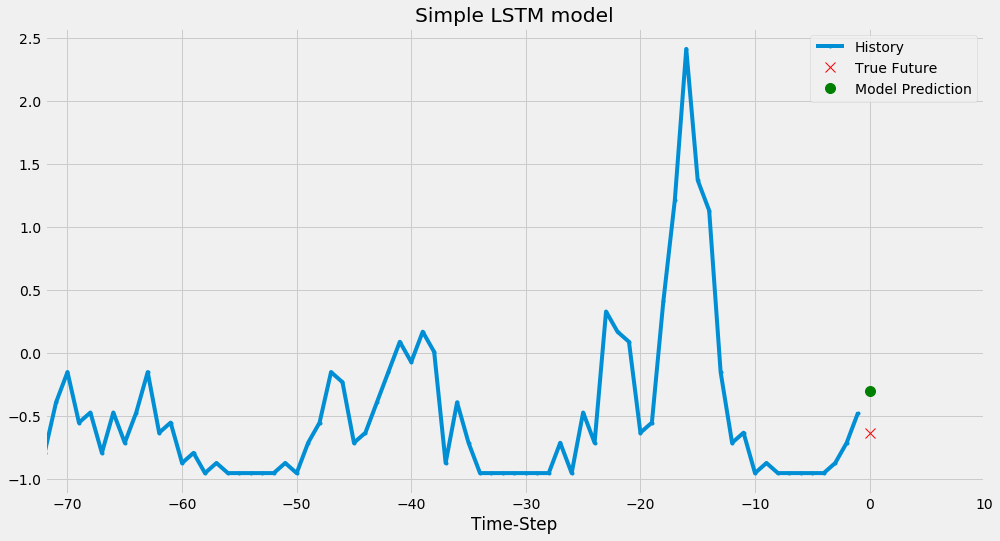

In [30]:
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()